In [1]:
import random

In [120]:
from matplotlib import pyplot as plt
%matplotlib inline

In [122]:
import seaborn as sns

In [134]:
def drawHand(deck, cardsToDraw):
    deck = deck[:]
    hand = []
    for card in range(cardsToDraw):
        hand.append(deck.pop())
    return (hand, deck)

In [135]:
def runMulliganTrial(deck, mulliganCount, cardsToDraw=16):
    random.shuffle(deck)
    hand, trialDeck = drawHand(deck, cardsToDraw)
    handStrengthBefore = sum(hand)
    mulls = []
    for i in range(mulliganCount):
        if (sum(deck) / len(deck)) > min(hand): #basic heuristic to not take bad EV mulligans
            mulls.append(min(hand))
            hand.remove(min(hand))
            hand.append(trialDeck.pop())
            
    deckStrength = sum(trialDeck) + sum(mulls)
    handStrengthAfter = sum(hand)
    return (handStrengthBefore, handStrengthAfter, deckStrength)

In [136]:
def gatherSamples(deck, mulliganCount, sampleSize):
    differences = []
    afters = []
    leftovers = []
    for i in range(sampleSize):
        before, after, deckStrength = runMulliganTrial(deck, mulliganCount)
        afters.append(after)
        differences.append(after - before)
        leftovers.append(deckStrength)
    return (differences, afters, leftovers)

In [151]:
def runExperiment(deck, numMulls, deckName, graph = False):
    differences, afters, leftovers = gatherSamples(deck, numMulls, 10000)
    
    avgGain = sum(differences) / len(differences)
    avgGainPerMull = avgGain / numMulls
    avgStrength = sum(afters) / len(afters)
    avgLeftovers = sum(leftovers) / len(leftovers)
    print(f"{numMulls} mulligans, {deckName}")
    print(f"average gain: {avgGain}")
    print(f"average gain per mulligan: {avgGainPerMull}")
    print(f"average value after mulligans:{avgStrength}")
    if graph:
        sns.countplot([int(x / 3) * 3 for x in afters])
    print(f"average value left in deck: {avgLeftovers}")
    print("")

Total Provisions: 165
Deck Size: 25

4 mulligans, balanced deck
average gain: 10.362
average gain per mulligan: 2.5905
average value after mulligans:116.0432
average value left in deck: 48.9568

3 mulligans, balanced deck
average gain: 7.8242
average gain per mulligan: 2.6080666666666668
average value after mulligans:113.5407
average value left in deck: 51.4593

2 mulligans, balanced deck
average gain: 5.1992
average gain per mulligan: 2.5996
average value after mulligans:110.8145
average value left in deck: 54.1855

1 mulligans, balanced deck
average gain: 2.5751
average gain per mulligan: 2.5751
average value after mulligans:108.185
average value left in deck: 56.815



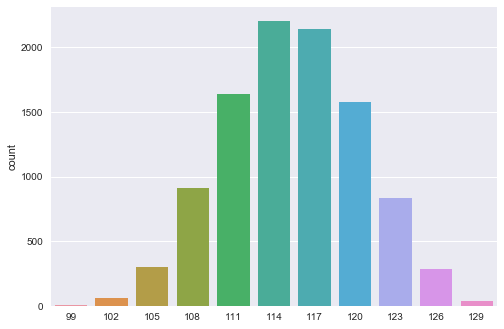

In [152]:
deck1 = ([4] * 10) + ([7] * 7) + ([8] * 2) + ([10] * 6) 
print(f"Total Provisions: %s" % sum(deck1))
print(f"Deck Size: %s\n" % len(deck1))

runExperiment(deck1, 4, "balanced deck", graph = True)
runExperiment(deck1, 3, "balanced deck")
runExperiment(deck1, 2, "balanced deck")
runExperiment(deck1, 1, "balanced deck")

Total Provisions: 165
Deck Size: 25

4 mulligans, topheavy deck
average gain: 10.4061
average gain per mulligan: 2.601525
average value after mulligans:115.9149
average value left in deck: 49.0851

3 mulligans, topheavy deck
average gain: 7.7554
average gain per mulligan: 2.5851333333333333
average value after mulligans:113.3824
average value left in deck: 51.6176

2 mulligans, topheavy deck
average gain: 5.1891
average gain per mulligan: 2.59455
average value after mulligans:110.7128
average value left in deck: 54.2872

1 mulligans, topheavy deck
average gain: 2.6472
average gain per mulligan: 2.6472
average value after mulligans:108.2341
average value left in deck: 56.7659



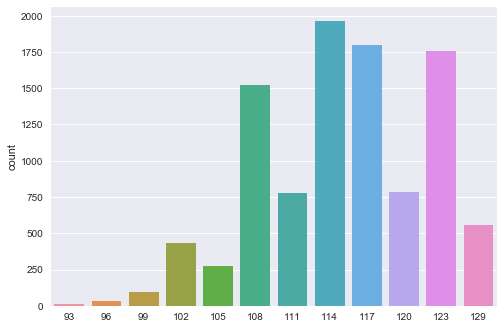

In [154]:
deck2 = ([4] * 15) + ([10] * 7) + [11] +  ([12] * 2) 
print(f"Total Provisions: %s" % sum(deck2))
print(f"Deck Size: %s\n" % len(deck2))

runExperiment(deck2, 4, "topheavy deck", graph=True)
runExperiment(deck2, 3, "topheavy deck")
runExperiment(deck2, 2, "topheavy deck")
runExperiment(deck2, 1, "topheavy deck")